In [71]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import warnings



I) On va d'abord traite les données afin de pouvoir les utiliser correctement par la suite.

In [72]:
warnings.filterwarnings("ignore")

crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [73]:
exchange_info = pd.read_csv("exchange_info_v2.csv")
exchange_info.head()

,Unnamed: 0,CeX,DeX
0,unfi-busd,1,0
1,iota-usd,1,0
2,bhp-usdt,1,0
3,dot-usdt,1,0
4,aave-usdt,1,0


In [74]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])
crix.head()


,date,price
0,2014-07-31,1000
1,2014-08-01,"1018,202717"
2,2014-08-02,"1008,772389"
3,2014-08-03,"1004,4165"
4,2014-08-04,"1004,984138"


In [75]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])
data_factors.head()




,timestamp,Mkt-RF,SMB,HML,RF
0,1926-07-01,"0,1","-0,25","-0,27","0,009"
1,1926-07-02,"0,45","-0,33","-0,06","0,009"
2,1926-07-06,"0,17","0,3","-0,39","0,009"
3,1926-07-07,"0,09","-0,58","0,02","0,009"
4,1926-07-08,"0,21","-0,38","0,19","0,009"


In [76]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

On implemente GetPortfolioCompo

In [77]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)

print(portfolios_df)

                                                  Portfolio_1  \
2021-02-01  [fund-usdt, doge-usdt, 1inch-usdt, gala-usdt, ...   
2021-03-01  [ersdl-usdt, matic-usdt, senso-usdt, pol-usdt,...   
2021-04-01  [storj-usd, steem-usdt, winx-usdt, win-usdt, b...   
2021-05-01  [pol-usdt, senso-usdt, ersdl-usdt, matic-usdt,...   
2021-06-01  [nmc-usdt, hnt-usdt, matic-usdt, hex-usdt, cel...   
2021-07-01  [fund-usdt, albt-usdt, strong-usdt, bid-usdt, ...   
2021-08-01  [ersdl-usdt, gala-usdt, hegic-usdt, sc-usdt, l...   
2021-09-01  [kp3r-usdt, strong-usdt, avax-usdt, sol-usdt, ...   
2021-10-01  [nmc-usdt, strong-usdt, atom-usdt, hex-usdt, a...   
2021-11-01  [mana-busd, sand-usdt, senso-usdt, bid-usdt, c...   
2021-12-01  [gala-usdt, sand-usdt, tncc-usdt, plu-usd, sto...   
2022-01-01  [sushi-usd, sushi-usdt, atom-usdt, kp3r-usdt, ...   
2022-02-01  [plu-usd, xor-usdt, wxt-usdt, snx-usdt, tusd-u...   
2022-03-01  [api3-usdt, atom-usdt, nmc-usdt, mx-usdt, unfi...   
2022-04-01  [jst-usdt, sr

On implemente UpdateValue, UpdateCompo et ComputePortfolioValue


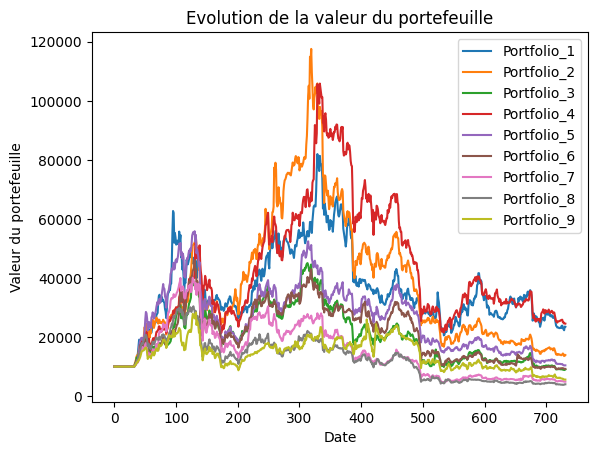

In [78]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}

for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()




Nous allons mettre en place le portefeuille P1-9.

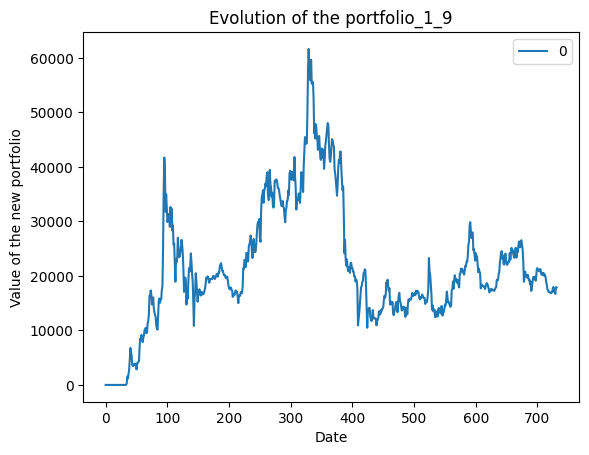

In [79]:
# Get the values of Portfolio 1 and the last portfolio
portfolio_1_values = portfolio_values_dict["Portfolio_1"]
last_portfolio_values = portfolio_values_dict[f"Portfolio_{len(portfolio_values_dict)}"]

# Create a new portfolio that buys Portfolio 1 and sells the last portfolio
portfolio_1_9 = pd.Series(portfolio_1_values) - pd.Series(last_portfolio_values)
#on convertit portfolio_1_9 en dataframe
portfolio_1_9 = pd.DataFrame(portfolio_1_9)
# Plot the values of all portfolios
portfolio_values_df = pd.DataFrame(portfolio_values_dict)
# Plot the new portfolio values P1_9
portfolio_1_9.plot(title='Evolution of the portfolio_1_9', xlabel='Date', ylabel='Value of the new portfolio')
plt.show()


Daily return for Portfolio i (1...9)

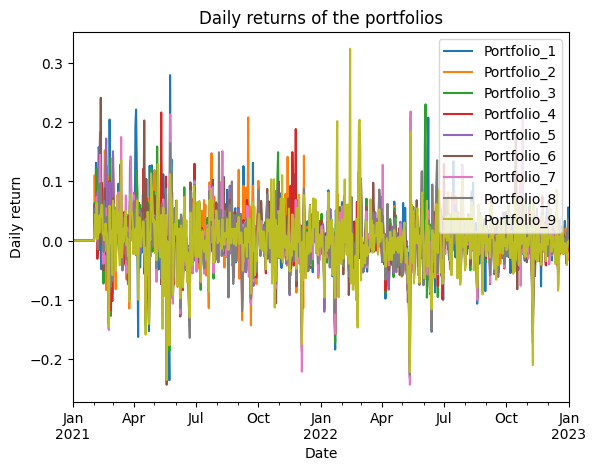

In [80]:
#on drop les nan
portfolio_values_df = portfolio_values_df.dropna()
#on drop la premiere ligne de portfolio_values_df
portfolio_values_df = portfolio_values_df.iloc[1:]
#on rajoute les timestamp de crypto_prices comme index de portfolio_values_df
portfolio_values_df.index = crypto_prices.index


portfolio_daily_returns = portfolio_values_df.pct_change()
portfolio_daily_returns.plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()



Daily return series R1-9

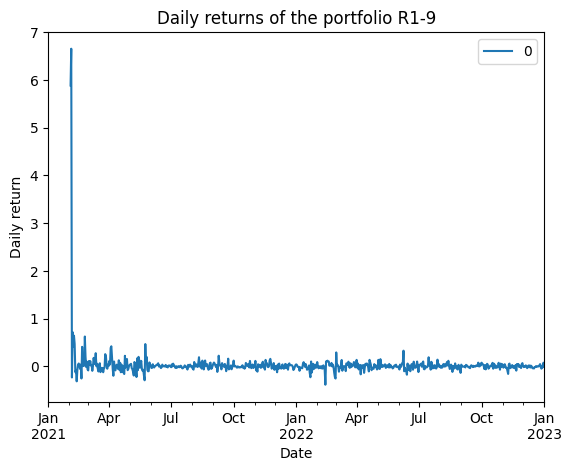

In [81]:
portfolio_1_9 = portfolio_1_9.iloc[1:]
portfolio_1_9.index = crypto_prices.index
portfolio_1_9_daily_returns = portfolio_1_9.pct_change()
portfolio_1_9_daily_returns.plot(title='Daily returns of the portfolio R1-9', xlabel='Date', ylabel='Daily return')
plt.show()


Daily return R1-R9

<AxesSubplot:title={'center':'Daily returns of the portfolio R1-R9'}, xlabel='Date', ylabel='Daily return'>

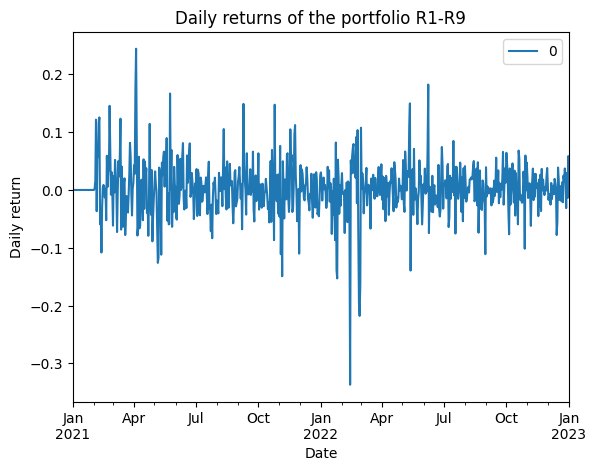

In [82]:
#on calcul et on affiche la difference de rentabilite entre le portefeuille 1 et le 9
portfolio_1_minus_9 = portfolio_daily_returns["Portfolio_1"] - portfolio_daily_returns["Portfolio_9"]
portfolio_1_minus_9 = pd.DataFrame(portfolio_1_minus_9)
portfolio_1_minus_9.index = crypto_prices.index
portfolio_1_minus_9.plot(title='Daily returns of the portfolio R1-R9', xlabel='Date', ylabel='Daily return')


On creer des dataframe contenant le RF associe à chaque timestamp afin de faciliter les calculs des ratios de sharpes.


In [83]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df = merged_df.loc[rebalancing_dates[0]:]
merged_df = merged_df.iloc[1:]


Statistiques sur les daily returns.

In [84]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_df.columns:
    returns = merged_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()

Indicators for Portfolio_1:
Mean: 0.0024189755428441623
Stddev: 0.04909171023676607
Median: 0.00044979488285279423
Min: -0.2354454012165209
Max: 0.27904042829100795
Skewness: 0.35327548213087545
Kurtosis: 4.534457832069984

Indicators for Portfolio_2:
Mean: 0.0015421065537396539
Stddev: 0.04610495381703023
Median: 0.002020784381006502
Min: -0.23399131987880273
Max: 0.2079784041952406
Skewness: -0.16798598793805183
Kurtosis: 2.663403491830193

Indicators for Portfolio_3:
Mean: 0.0008975287440794944
Stddev: 0.04537432510338965
Median: 0.0013356182989860965
Min: -0.20423867559770226
Max: 0.22977989445527802
Skewness: -0.27138779999522405
Kurtosis: 3.439491807244904

Indicators for Portfolio_4:
Mean: 0.0022482924202351863
Stddev: 0.043802916095904185
Median: 0.0027760074353029296
Min: -0.173569784239326
Max: 0.21609208940337776
Skewness: -0.06198672151397107
Kurtosis: 2.7934979474108896

Indicators for Portfolio_5:
Mean: 0.0009571849867231523
Stddev: 0.04212976575367125
Median: 0.002613988

In [85]:
#on soustrait RF à chaque daily return
merged_df['Portfolio_1'] = merged_df['Portfolio_1'] - merged_df['RF']
merged_df['Portfolio_2'] = merged_df['Portfolio_2'] - merged_df['RF']
merged_df['Portfolio_3'] = merged_df['Portfolio_3'] - merged_df['RF']
merged_df['Portfolio_4'] = merged_df['Portfolio_4'] - merged_df['RF']
merged_df['Portfolio_5'] = merged_df['Portfolio_5'] - merged_df['RF']
merged_df['Portfolio_6'] = merged_df['Portfolio_6'] - merged_df['RF']
merged_df['Portfolio_7'] = merged_df['Portfolio_7'] - merged_df['RF']
merged_df['Portfolio_8'] = merged_df['Portfolio_8'] - merged_df['RF']
merged_df['Portfolio_9'] = merged_df['Portfolio_9'] - merged_df['RF']


On fait R-RF pour le portefeuille R1-9

In [86]:
rf_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df_1_9['RF'].fillna(method='ffill', inplace=True)
rf_df_1_9['RF'] = rf_df_1_9['RF'].str.replace(',', '.').astype(float)

merged_df_1_9 = portfolio_1_9_daily_returns.merge(rf_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df_1_9 = merged_df_1_9.loc[rebalancing_dates[0]:]
merged_df_1_9 = merged_df_1_9.iloc[2:]
merged_df_1_9[0] = merged_df_1_9[0] - merged_df_1_9['RF']
merged_df_1_9.head()

,0,RF
timestamp,,
2021-02-03,5.880045,0.0
2021-02-04,6.650282,0.0
2021-02-05,-0.233401,0.0
2021-02-06,0.716195,0.0
2021-02-07,0.407996,0.0


Ratio de sharpe pour les portefeuille 1 à 9

In [87]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_df.mean()) / merged_df.std()
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:9])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.048671
Portfolio_2    0.032806
Portfolio_3    0.019130
Portfolio_4    0.050651
Portfolio_5    0.022018
Portfolio_6    0.018929
Portfolio_7    0.001003
Portfolio_8   -0.007895
Portfolio_9    0.008511
dtype: float64


Ratio de sharpe Portefeuille P1-9

In [88]:
sharpe_ratio_p1_9 = merged_df_1_9.mean() / merged_df_1_9.std()
print("Le ratio de sharpe du portefeuille P1-9 est :", sharpe_ratio_p1_9[0])

Le ratio de sharpe du portefeuille P1-9 est : 0.06431662830344133


Ratio de sharpe de R1-R9

In [89]:
ratio_sharpe_portfolio_1_minus_9 = portfolio_1_minus_9.mean() / portfolio_1_minus_9.std()
print("Le ratio de Sharpe de portfolio_1_minus_9 est :", ratio_sharpe_portfolio_1_minus_9[0])


Le ratio de Sharpe de portfolio_1_minus_9 est : 0.04035864175686419


Nous souhaitons maintenant calculer les ratio de Treynor ainsi que l'alpha de Jensen.
Comme précedemment on creer donc les DF associés afin de faciliter nos calculs.

In [90]:

mkt_RF_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df['Mkt-RF'] = mkt_RF_df['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df = merged_df.merge(mkt_RF_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df = merged_mkt_RF_df.loc[rebalancing_dates[0]:]
merged_mkt_RF_df = merged_mkt_RF_df.iloc[1:]

merged_mkt_RF_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


In [91]:
mkt_RF_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_9['Mkt-RF'] = mkt_RF_df_1_9['Mkt-RF'].str.replace(',', '.').astype(float)

merged_mkt_RF_df_1_9 = portfolio_1_9_daily_returns.merge(mkt_RF_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.iloc[2:]

In [92]:

mkt_RF_df_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_minus_9['Mkt-RF'] = mkt_RF_df_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)

merged_mkt_RF_df_1_minus_9 = portfolio_1_minus_9.merge(mkt_RF_df_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.iloc[2:]

In [93]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_mkt_RF_df['Mkt-RF']
    y = merged_mkt_RF_df[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha = results.params[0]
    beta = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha}')
    print(f'Beta (Market): {beta}')
    print()

# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_9['Mkt-RF']
y = merged_mkt_RF_df_1_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_9 = results.params[0]
beta_1_9 = results.params[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_9:')
print(f'Alpha (Jensen): {alpha_1_9}')
print(f'Beta (Market): {beta_1_9}')
print()

# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_minus_9['Mkt-RF']
y = merged_mkt_RF_df_1_minus_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_minus_9 = results.params[0]
beta_1_minus_9 = results.params[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_minus_9:')
print(f'Alpha (Jensen): {alpha_1_minus_9}')
print(f'Beta (Market): {beta_1_minus_9}')
print()



Portfolio_1:
Alpha (Jensen): 0.002211051965643519
Beta (Market): 0.9668945659725882

Portfolio_2:
Alpha (Jensen): 0.0012218331155011012
Beta (Market): 0.8631491632186671

Portfolio_3:
Alpha (Jensen): 0.0006644494806484474
Beta (Market): 0.7247641113387633

Portfolio_4:
Alpha (Jensen): 0.002057938243443774
Beta (Market): 0.72863776374779

Portfolio_5:
Alpha (Jensen): 0.0007752319798164464
Beta (Market): 0.6985207364816501

Portfolio_6:
Alpha (Jensen): 0.0006241096234047731
Beta (Market): 0.7716782988465907

Portfolio_7:
Alpha (Jensen): -0.00013394788592596563
Beta (Market): 0.9298103120554839

Portfolio_8:
Alpha (Jensen): -0.0005540491522037425
Beta (Market): 0.8879396501442148

Portfolio_9:
Alpha (Jensen): 0.00024568374310872566
Beta (Market): 1.0151355577082932

Portfolio_1_9:
Alpha (Jensen): 0.025065970739928695
Beta (Market): 0.01698598754495311

Portfolio_1_minus_9:
Alpha (Jensen): 0.001965368222534794
Beta (Market): -0.00048240991735705116



Calcul ratio de treyor Portefeuille 1 à 9.

In [94]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_df.mean()) / beta
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:9])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002354
Portfolio_2    0.001490
Portfolio_3    0.000855
Portfolio_4    0.002186
Portfolio_5    0.000914
Portfolio_6    0.000819
Portfolio_7    0.000046
Portfolio_8   -0.000342
Portfolio_9    0.000424
dtype: float64


Calcul ratio de treynor portefeuille P1-9

In [95]:
#on calcul le ration de sharpe pour le portefeuille P1-9
treynor_ratios_1_9_portfolio = (merged_mkt_RF_df_1_9.mean() ) / beta_1_9
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_1_9_portfolio[0])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 1.4913585708305184


Calcul ratio de treynor R1-R9.

In [96]:
#on calcul le ration de sharpe pour le portefeuille R1-R9
treynor_ratios_1_minus_9_portfolio = (merged_mkt_RF_df_1_minus_9.mean() ) / beta_1_minus_9
print("Le ratio de treynor du portefeuille 1 moins le portefeuile 9 :","\n",treynor_ratios_1_minus_9_portfolio[0])

Le ratio de treynor du portefeuille 1 moins le portefeuile 9 : 
 -4.058389289772023


On passe à la simulation de FAMA & FRENCH

In [103]:
fm_portfolios = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolios['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolios['Mkt-RF'] = fm_portfolios['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolios['HML'].fillna(method='ffill', inplace=True)
fm_portfolios['HML'] = fm_portfolios['HML'].str.replace(',', '.').astype(float)/100
fm_portfolios['SMB'].fillna(method='ffill', inplace=True)
fm_portfolios['SMB'] = fm_portfolios['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolios = merged_df.merge(fm_portfolios, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolios = fm_portfolios.loc[rebalancing_dates[0]:]
fm_portfolios.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.110044,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


On fait la regression.

In [112]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_portfolios[['Mkt-RF', 'SMB', 'HML']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha}")


Coefficients:
Portfolio_1: Bmarket=0.961501598136943, Bsmb=0.3386565420854252, Bhml=0.1523865755762788
Portfolio_2: Bmarket=0.8988204026970165, Bsmb=-0.003076044116250784, Bhml=0.06741455974486985
Portfolio_3: Bmarket=0.7401957600397763, Bsmb=0.00881385068594252, Bhml=0.030466685721396217
Portfolio_4: Bmarket=0.7762491242776941, Bsmb=-0.12414204804965315, Bhml=0.06725971211621647
Portfolio_5: Bmarket=0.6892136830344119, Bsmb=0.1484986630421088, Bhml=0.0405720089702994
Portfolio_6: Bmarket=0.7970888501534195, Bsmb=-0.15314776212462597, Bhml=-0.02078956105174091
Portfolio_7: Bmarket=0.9427518630452788, Bsmb=-0.0814378599373918, Bhml=-0.0072823761154558134
Portfolio_8: Bmarket=0.9407711446358734, Bsmb=-0.24642929482987236, Bhml=0.016681216833179163
Portfolio_9: Bmarket=1.0720521800696237, Bsmb=-0.04226341823265052, Bhml=0.14171557836175208

Alphas:
Portfolio_1: Alpha=0.00212010236296028
Portfolio_2: Alpha=0.0012739655921453897
Portfolio_3: Alpha=0.0007031946612244024
Portfolio_4: Alpha=0.